In [15]:
import numpy as np
import pandas as pd
import random

import torch
import torch.nn as nn
import torch.nn.functional as F

import seaborn as sns
import matplotlib.pyplot as plt
import os

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from collections import OrderedDict
from tqdm import tqdm

import warnings
warnings.filterwarnings("ignore")

In [16]:
# CUDA support 
if torch.cuda.is_available():
    device = torch.device('cuda:2')
else:
    device = torch.device('cpu')
    
print(device)
device = torch.device('cpu')

cuda:2


In [17]:
# the deep neural network
class MLP(torch.nn.Module):
    def __init__(self, layers, activation="relu", init="xavier"):
        super(MLP, self).__init__()
        
        # parameters
        self.depth = len(layers) - 1
        
        if activation == "relu":
            self.activation = torch.nn.ReLU()
        elif activation == "tanh":
            self.activation = torch.nn.Tanh()
        elif activation == "gelu":
            self.activation = torch.nn.GELU()
        else:
            raise ValueError("Unspecified activation type")
        
        
        layer_list = list()
        for i in range(self.depth - 1): 
            layer_list.append(
                ('layer_%d' % i, torch.nn.Linear(layers[i], layers[i+1]))
            )
            layer_list.append(('activation_%d' % i, self.activation))
            
        layer_list.append(
            ('layer_%d' % (self.depth - 1), torch.nn.Linear(layers[-2], layers[-1]))
        )
        layerDict = OrderedDict(layer_list)
        
        # deploy layers
        self.layers = torch.nn.Sequential(layerDict)

        if init=="xavier":
            self.xavier_init_weights()
        elif init=="kaiming":
            self.kaiming_init_weights()
    
    def xavier_init_weights(self):
        with torch.no_grad():
            print("Initializing Network with Xavier Initialization..")
            for m in self.layers.modules():
                if hasattr(m, 'weight'):
                    nn.init.xavier_uniform_(m.weight)
                    m.bias.data.fill_(0.0)

    def kaiming_init_weights(self):
        with torch.no_grad():
            print("Initializing Network with Kaiming Initialization..")
            for m in self.layers.modules():
                if hasattr(m, 'weight'):
                    nn.init.kaiming_uniform_(m.weight)
                    m.bias.data.fill_(0.0)
                        
    def forward(self, x):
        out = self.layers(x)
        return out
    
class DataGenerator(torch.utils.data.Dataset):
    def __init__(self, X, Y):
        self.X = X
        self.Y = Y
        
    def __getitem__(self, index):
        return self.X[index], self.Y[index]
    
    def __len__(self):
        return len(self.X)

In [18]:
data_df = pd.read_csv("all_data_lake_modeling_in_time.csv")
data_df = data_df.drop(columns=['time'])
data_df

,depth,AirTemp_degC,Longwave_Wm-2,Latent_Wm-2,Sensible_Wm-2,Shortwave_Wm-2,lightExtinct_m-1,ShearVelocity_mS-1,ShearStress_Nm-2,Area_m2,...,day_of_year,time_of_day,temp_mix03,temp_conv04,temp_initial00,obs_temp,input_obs,ice,snow,snowice
0,1,-1.260530,565.10046,-4.184752,-4.714701,0.0,0.4,-999.0,-999.0,39850000.0,...,364,1,-0.115875,-0.115875,-0.019025,5.558093,5.560076,0.000000,0.000000,0.000000
1,2,-1.260530,565.10046,-4.184752,-4.714701,0.0,0.4,-999.0,-999.0,39850000.0,...,364,1,0.470220,0.470220,-0.019025,4.870203,4.876163,0.000000,0.000000,0.000000
2,3,-1.260530,565.10046,-4.184752,-4.714701,0.0,0.4,-999.0,-999.0,39850000.0,...,364,1,1.092054,1.073671,0.046866,5.106928,5.112209,0.000000,0.000000,0.000000
3,4,-1.260530,565.10046,-4.184752,-4.714701,0.0,0.4,-999.0,-999.0,39850000.0,...,364,1,1.054755,1.073671,0.799295,5.106928,5.112209,0.000000,0.000000,0.000000
4,5,-1.260530,565.10046,-4.184752,-4.714701,0.0,0.4,-999.0,-999.0,39850000.0,...,364,1,1.312011,1.312011,1.381341,5.106928,5.112209,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1752345,46,-3.080809,529.16738,-15.814628,-20.288304,0.0,0.4,-999.0,-999.0,39850000.0,...,362,23,4.155746,4.155746,4.155679,4.045759,4.047768,0.283046,0.025199,0.044785
1752346,47,-3.080809,529.16738,-15.814628,-20.288304,0.0,0.4,-999.0,-999.0,39850000.0,...,362,23,4.250744,4.250744,4.250654,4.435799,4.438573,0.283046,0.025199,0.044785
1752347,48,-3.080809,529.16738,-15.814628,-20.288304,0.0,0.4,-999.0,-999.0,39850000.0,...,362,23,4.347902,4.347902,4.347777,5.532094,5.534868,0.283046,0.025199,0.044785
1752348,49,-3.080809,529.16738,-15.814628,-20.288304,0.0,0.4,-999.0,-999.0,39850000.0,...,362,23,4.438525,4.438525,4.438403,7.391329,7.391820,0.283046,0.025199,0.044785


In [19]:
training_frac = 0.60
depth_steps = 25
number_days = len(data_df)//depth_steps
n_obs = int(number_days*training_frac)*depth_steps
print(f"Number of days total: {number_days}")
print(f"Number of training points: {n_obs}")

Number of days total: 70094
Number of training points: 1051400


# Normalizing Data

In [20]:
data = data_df.values

train_data = data[:n_obs]
test_data = data[n_obs:]

#performing normalization on all the columns
scaler = StandardScaler()
scaler.fit(train_data)
train_data = scaler.transform(train_data)
test_data = scaler.transform(test_data)

# Training Heat Diffusion Model

In [21]:
input_columns = ['depth', 'AirTemp_degC', 'Longwave_Wm-2', 'Latent_Wm-2', 'Sensible_Wm-2', 'Shortwave_Wm-2',
                'lightExtinct_m-1','Area_m2', 'Uw',
                 'day_of_year', 'time_of_day',  
                 'buoyancy', 'diffusivity', 'temp_initial00', 
                'temp_heat01', 'temp_diff02', 'temp_total05',
                'ice', 'snow', 'snowice']
output_columns = ['temp_conv04']

input_column_ix = [data_df.columns.get_loc(column) for column in input_columns]
output_column_ix = [data_df.columns.get_loc(column) for column in output_columns]

X_train, X_test = train_data[:,input_column_ix], test_data[:,input_column_ix]
y_train, y_test = train_data[:,output_column_ix], test_data[:,output_column_ix]

In [22]:
print(f"X_train: {X_train.shape}, X_test: {X_test.shape}")
print(f"y_train: {y_train.shape}, y_test: {y_test.shape}")

X_train: (1051400, 20), X_test: (700950, 20)
y_train: (1051400, 1), y_test: (700950, 1)


In [23]:
#keeping track of the mean and standard deviations
train_mean = scaler.mean_
train_std = scaler.scale_

input_mean, input_std = train_mean[input_column_ix], train_std[input_column_ix]
output_mean, output_std = train_mean[output_column_ix], train_std[output_column_ix]

In [24]:
# Create data set
batch_size = 1024
train_dataset = DataGenerator(X_train, y_train)
test_dataset = DataGenerator(X_test, y_test)
# train_dataset = torch.utils.data.TensorDataset(X_train, y_train)
# test_dataset = torch.utils.data.TensorDataset(X_test, y_test)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, 
                                           shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size,
                                          shuffle=False)

In [25]:
layers = [X_train.shape[-1], 32, 32,32,32,32,32,32,32,32,32, y_train.shape[-1]]

model = MLP(layers, activation="gelu").to(device)

Initializing Network with Xavier Initialization..


In [26]:
lr = 1e-3
decay_rate = 0.1
decay_steps = 500
    
optimizer = torch.optim.Adam(model.parameters(), lr=lr, 
                         betas=(0.9, 0.999), eps=1e-08, weight_decay=0, amsgrad=False)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=decay_steps, gamma=decay_rate)

criterion = torch.nn.MSELoss()

In [27]:
print(model)

MLP(
  (activation): GELU()
  (layers): Sequential(
    (layer_0): Linear(in_features=20, out_features=32, bias=True)
    (activation_0): GELU()
    (layer_1): Linear(in_features=32, out_features=32, bias=True)
    (activation_1): GELU()
    (layer_2): Linear(in_features=32, out_features=32, bias=True)
    (activation_2): GELU()
    (layer_3): Linear(in_features=32, out_features=32, bias=True)
    (activation_3): GELU()
    (layer_4): Linear(in_features=32, out_features=32, bias=True)
    (activation_4): GELU()
    (layer_5): Linear(in_features=32, out_features=32, bias=True)
    (activation_5): GELU()
    (layer_6): Linear(in_features=32, out_features=32, bias=True)
    (activation_6): GELU()
    (layer_7): Linear(in_features=32, out_features=32, bias=True)
    (activation_7): GELU()
    (layer_8): Linear(in_features=32, out_features=32, bias=True)
    (activation_8): GELU()
    (layer_9): Linear(in_features=32, out_features=32, bias=True)
    (activation_9): GELU()
    (layer_10): Li

In [28]:
n_epochs = 100

train_loss = []
test_loss = []
for it in tqdm(range(n_epochs)):
    loss_epoch = 0
    model.train()
    for x, y in iter(train_loader):
        x, y = x.to(device).float(), y.to(device).float()
        optimizer.zero_grad()
        pred = model(x)
        loss = criterion(pred, y)
        loss.backward()
        optimizer.step()
        loss_epoch += loss.detach().item()
    lr_scheduler.step()
    
    if it % 50 == 0:
        train_loss.append(loss_epoch/len(train_loader))
        model.eval()
        test_loss_epoch = 0
        for x, y in iter(test_loader):
            x, y = x.to(device).float(), y.to(device).float()
            pred = model(x)
            loss = criterion(pred, y)
            test_loss_epoch += loss.detach().item()
        test_loss.append(test_loss_epoch/len(test_loader))
        print(f"Epoch : {it}, Train_loss: {train_loss[-1]}, Test_loss: {test_loss[-1]}")
    

  1%|          | 1/100 [00:20<34:25, 20.86s/it]

Epoch : 0, Train_loss: 0.027673622395649657, Test_loss: 0.0003046803345024691


 51%|█████     | 51/100 [12:39<14:02, 17.20s/it]

Epoch : 50, Train_loss: 1.3478773429085046e-05, Test_loss: 1.5178695136196737e-05


100%|██████████| 100/100 [24:56<00:00, 14.96s/it]


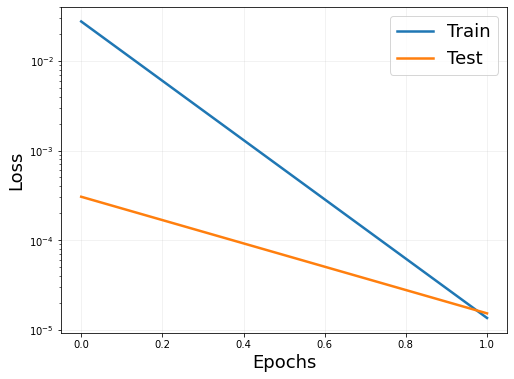

In [29]:
plt.figure(figsize=(8,6))
plt.plot(train_loss, label="Train", linewidth=2.5)
plt.plot(test_loss, label="Test", linewidth=2.5)
plt.grid("on", alpha=0.2)
plt.legend(fontsize=18)
plt.yscale("log")
plt.xlabel("Epochs", fontsize=18)
plt.ylabel("Loss", fontsize=18)
plt.show()

# Evaluating Results

In [30]:
def rmse(true, pred):
    return (((true-pred)**2).mean()**0.5).detach().cpu().numpy()

def l2_error(true, pred):
    return np.linalg.norm(pred.detach().cpu().numpy() - true.detach().cpu().numpy()) / np.linalg.norm(true.detach().cpu().numpy()) 

def compute_metrics(model, loader, mean=0.0, std=1.0):
    model.eval()
    y_ = []
    pred_ = []
    mean = torch.tensor(mean).to(device)
    std = torch.tensor(std).to(device)
    for x, y in iter(loader):
        x, y = x.to(device).float(), y.to(device).float()
        pred = model(x)
        y = y * std + mean
        pred = pred * std + mean
        y_.append(y)
        pred_.append(pred)
    y_ = torch.cat(y_, dim=0) 
    pred_ = torch.cat(pred_, dim=0)
    
    rmse_temp = rmse(y_[:,0], pred_[:,0])
    
    l2_error_temp = l2_error(y_[:,0], pred_[:,0])
    return rmse_temp, l2_error_temp

In [31]:
rmse_temp, l2_error_temp = compute_metrics(model, test_loader,  mean = output_mean, std = output_std)
print(f"Test Rmse of Temp: {rmse_temp}")
print(f"L2 Error  of Temp: {l2_error_temp}")

Test Rmse of Temp: 0.02110645765014702
L2 Error  of Temp: 0.0024682221563640276


In [32]:
rmse_temp, l2_error_temp = compute_metrics(model, train_loader,  mean = output_mean, std = output_std)
print(f"Train Rmse of Temp: {rmse_temp}")
print(f"L2 Error  of Temp: {l2_error_temp}")

Train Rmse of Temp: 0.019015189840326855
L2 Error  of Temp: 0.0025319455239322815


# Saving Model

In [33]:
PATH = f"./saved_models/direct_model_train_time.pth"
torch.save(model.state_dict(), PATH)

In [34]:
output_mean

array([5.52802599])